In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [2]:
# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [3]:
# Set parameters.
L = 0.06  # length of the rod
nx = 51  # number of locations on the rod
dx = L / (nx - 1)  # distance between two consecutive locations
rho = 1490
k = 0.8
Cp = 1050
alpha = k/(rho*Cp) 

#rho = 50
#k = 0.04
#Cp = 850000
#alpha1 = k/(rho*Cp)  #  thermal diffusivity of the rod

# Define the locations along the rod.
x = numpy.linspace(0.0, L, num=nx)

# Set the initial temperature along the rod.
T0 = numpy.zeros(nx)
T0[:]=293
Tinf = 293
#T0[0] = 850

Area = 0.1914
h = 30

boltzmann = 5.6704E-08

Qdot_in = 2500


print(alpha)

5.113454777884309e-07


In [4]:
from scipy import linalg

In [5]:
def lhs_operator(N, sigma):
    """
    Computes and returns the implicit operator
    of the system for the 1D diffusion equation.
    We use backward Euler method, Dirichlet condition
    on the left side of the domain and zero-gradient
    Neumann condition on the right side.
    
    Parameters
    ----------
    N : integer
        Number of interior points.
    sigma : float
        Value of alpha * dt / dx**2.
    
    Returns
    -------
    A : numpy.ndarray
        The implicit operator as a 2D array of floats
        of size N by N.
    """
    # Setup the diagonal of the operator.
    D = numpy.diag((2.0 + 1.0 / sigma) * numpy.ones(N))
    # Setup the Neumann condition for the first element.
    D[0, 0] = 1.0 + 1.0 / sigma
    # Setup the Neumann condition for the last element.
    D[-1, -1] = 1.0 + 1.0 / sigma
    # Setup the upper diagonal of the operator.
    U = numpy.diag(-1.0 * numpy.ones(N - 1), k=1)
    # Setup the lower diagonal of the operator.
    L = numpy.diag(-1.0 * numpy.ones(N - 1), k=-1)
    # Assemble the operator.
    A = D + U + L
    return A

In [6]:
def rhs_vector(T, sigma,Qdot_in, Qdot_out,heatfac):
    """
    Computes and returns the right-hand side of the system
    for the 1D diffusion equation, using a Dirichlet condition
    on the left side and a Neumann condition on the right side.
    
    Parameters
    ----------
    T : numpy.ndarray
        The temperature distribution as a 1D array of floats.
    sigma : float
        Value of alpha * dt / dx**2.
    qdx : float
        Value of the temperature flux at the right side.
    
    Returns
    -------
    b : numpy.ndarray
        The right-hand side of the system as a 1D array of floats.
    """
    #print(Qdot_out)
    b = T[1:-1] / sigma
    # Set Dirichlet condition.
    #b[0] += T[0]
    # Set Neumann condition.
    b[0] = b[0] +Qdot_in/Area*dx
    # Set Neumann condition.
    b[-1] = b[-1]-Qdot_out/Area*dx
    return b

In [7]:
def btcs_implicit(T0, nt, dt, dx, alpha,heatfac):
    """
    Computes and returns the temperature along the rod
    after a given number of time steps.
    
    The function uses Euler implicit in time,
    central differencing in space, a Dirichlet condition
    on the left side, and a Neumann condition on the
    right side.
    
    Parameters
    ----------
    T0 : numpy.ndarray
        The initial temperature distribution as a 1D array of floats.
    nt : integer
        Number of time steps to compute.
    dt : float
        Time-step size.
    dx : float
        Distance between two consecutive locations.
    alpha : float
        Thermal diffusivity of the rod.
    q : float
        Value of the temperature gradient on the right side.
    
    Returns
    -------
    T : numpy.ndarray
        The temperature distribution as a 1D array of floats.
    """
    sigma = alpha * dt / dx**2
    # Create the implicit operator of the system.
    A = lhs_operator(len(T0) - 2, sigma)
    # Integrate in time.
    T = T0.copy()
    for n in range(nt):

        Qdot_out = boltzmann * Area *(T[-1]**4-Tinf**4)+h*Area*(T[-1]-Tinf)
        
        
        # Generate the right-hand side of the system.
        b = rhs_vector(T, sigma, Qdot_in,Qdot_out,heatfac)
        # Solve the system with scipy.linalg.solve.
        T[1:-1] = linalg.solve(A, b)
        
        # Apply Neumann conditions.
        
        #T[-1] = T[-1]+sigma*(T[-2]-T[-1]-heatfac * Qdot_out)
        T[-1] = T[-2]-Qdot_out/Area*dx
        #T[0] = T[0]+sigma*(T[1]-T[0]+heatfac*Qdot_in)
        T[0] = T[1]+ Qdot_in/Area*dx
    return T

In [8]:
# Set the time-step size based on CFL limit.
sigma = 1
dt = sigma * dx**2 / alpha  # time-step size
heatfac = dx/(k*Area)
print(dt)
#print(heatfac)
Tfinal = 1.25*3600
nt = int(Tfinal/dt)
print(nt)
# Compute the temperature along the rod.
T = btcs_implicit(T0, nt, dt, dx, alpha,heatfac)

2.816099999999999
1597


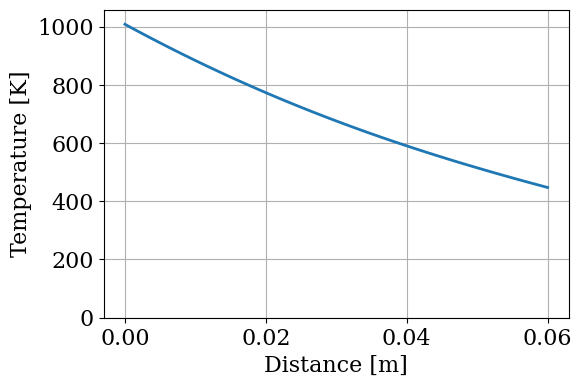

In [9]:
# Plot the temperature along the rod.
pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel('Distance [m]')
pyplot.ylabel('Temperature [K]')
pyplot.grid()
pyplot.plot(x, T, color='C0', linestyle='-', linewidth=2)
#pyplot.xlim(0.0, L)
pyplot.ylim(0.0, T[0]+50);

In [10]:
T[0],T[-1]

(1007.8507693236091, 447.30351842764946)